In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from PIL import Image
!pip install -U accelerate
!pip install -U transformers
!pip install transformers[torch]
!pip install accelerate -U
!pip install rouge_score
!pip install evaluate
from transformers import AutoTokenizer
import evaluate
import torch
from PIL import Image
import matplotlib.pyplot as plt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.6/227.6 kB 9.0 MB/s eta 0:00:00
  Attempting uninstall: accelerate
    Found existing installation: accelerate 0.12.0
    Uninstalling accelerate-0.12.0:
      Successfully uninstalled accelerate-0.12.0
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 63.8 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 4.30.1
    Uninstalling transformers-4.30.1:
      Successfully uninstalled transformers-4.30.1
  Preparing metadata (setup.py) ... - \ done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24954 sha256=dfe5cef0eff49ba99b1add25a64fee59e24f06d920a64b224395680dfb40cd72
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge_score
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 3.9 MB/s eta 0:00:00


/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

# Importing Text Data

In [2]:
text_data = pd.read_csv('/kaggle/input/flickr8k/captions.txt', sep='|')
text_data

image_name  caption_number  \
0      1000268201_693b08cb0e.jpg               0   
1      1000268201_693b08cb0e.jpg               1   
2      1000268201_693b08cb0e.jpg               2   
3      1000268201_693b08cb0e.jpg               3   
4      1000268201_693b08cb0e.jpg               4   
...                          ...             ...   
40450   997722733_0cb5439472.jpg               0   
40451   997722733_0cb5439472.jpg               1   
40452   997722733_0cb5439472.jpg               2   
40453   997722733_0cb5439472.jpg               3   
40454   997722733_0cb5439472.jpg               5   

                                            caption_text  
0      A child in a pink dress is climbing up a set o...  
1                  A girl going into a wooden building .  
2       A little girl climbing into a wooden playhouse .  
3      A little girl climbing the stairs to her playh...  
4      A little girl in a pink dress going into a woo...  
...                                                  ...  
40450           A man in a pink shirt climbs a rock face  
40451           A man is rock climbing high in the air .  
40452  A person in a red shirt climbing up a rock fac...  
40453                    A rock climber in a red shirt .  
40454  A rock climber practices on a rock climbing wa...  

[40455 rows x 3 columns]

# Data Preparation

In [3]:
text_data = pd.read_csv('/kaggle/input/flickr8k/captions.txt', sep='|')
text_data.rename(columns={"caption_number":"image_repeat","caption_text":"caption"},inplace=True)
text_data.drop(text_data[text_data['image_name']=="2258277193_586949ec62.jpg.1"].index, inplace=True)
text_data.reset_index(drop=True, inplace=True)

In [4]:
# Drop rows with given value of column
text_data_train = text_data.drop(text_data[text_data['image_repeat']==0].index)
text_data_train.reset_index(drop=True, inplace=True)

# text_data_train = text_data[text_data['image_repeat']==1]
# text_data_train.reset_index(drop=True, inplace=True)
text_data_val = text_data[ text_data['image_repeat']==0 ]
text_data_val.reset_index(drop=True, inplace=True)
text_data_train.shape, text_data_val.shape

((32364, 3), (8091, 3))

# Vision Encoder Decoder Models

In [5]:
batch_size = 32
epochs = 20

In [6]:
from transformers import AutoImageProcessor, AutoTokenizer, VisionEncoderDecoderModel
from PIL import Image
import requests

image_processor = AutoImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")
decoder_tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased", add_special_tokens=True)

if decoder_tokenizer.pad_token is None:
    decoder_tokenizer.add_special_tokens({'pad_token': '[PAD]'})

model = VisionEncoderDecoderModel.from_encoder_decoder_pretrained("google/vit-base-patch16-224-in21k", "bert-base-uncased")

# ids
model.config.decoder_start_token_id = decoder_tokenizer.cls_token_id
model.config.pad_token_id = decoder_tokenizer.pad_token_id
model.config.vocab_size = model.config.decoder.vocab_size

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertLMHeadModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertLMHeadModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertLMHeadModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertLMHeadModel were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['bert.encoder.layer.5.crossattention.self.value.bias', 'bert.encoder.layer.0.crossattention.output.dense.bias', 'bert.encoder.layer.2.crossattention.self.value.weight', 'bert.encoder.layer.2.crossattention.self.value.bias', 'bert.encoder.l

In [7]:
from torch.utils.data import Dataset
# from datasets import Dataset
image_height = 224
image_width = 224

class ImageCaptionDataset(Dataset):
    def __init__(self, image_path, text_df, tokenizer, image_height,image_width):
        self.image_path = image_path
        self.text_df = text_df
        self.tokenizer = tokenizer
        self.image_height = image_height
        self.image_width = image_width
        
    def __len__(self):
        return self.text_df.shape[0]
    
    def __getitem__(self,index):
        path_filename = self.image_path + text_data_train.iloc[index]['image_name']
        image = np.array(Image.open( path_filename ).resize((self.image_width, self.image_height)), dtype=np.uint8)
        image = torch.tensor(np.moveaxis(image, -1, 0))
        caption_token = self.tokenizer( text_data_train.iloc[index]['caption'], add_special_tokens=True, padding="max_length", max_length=32, truncation = True  ).input_ids 
        caption_token = [token if token != self.tokenizer.pad_token_id else -100 for token in caption_token] 
        return {"pixel_values": image.squeeze(), "caption_token": torch.tensor(caption_token)} #, "caption":self.captions[index]}


train_dataset = ImageCaptionDataset( image_path="/kaggle/input/flickr8k/images/", text_df=text_data_train , tokenizer=decoder_tokenizer, image_height=224, image_width=224 )
val_dataset = ImageCaptionDataset( image_path="/kaggle/input/flickr8k/images/", text_df=text_data_val , tokenizer=decoder_tokenizer, image_height=224, image_width=224 )

# Display few images

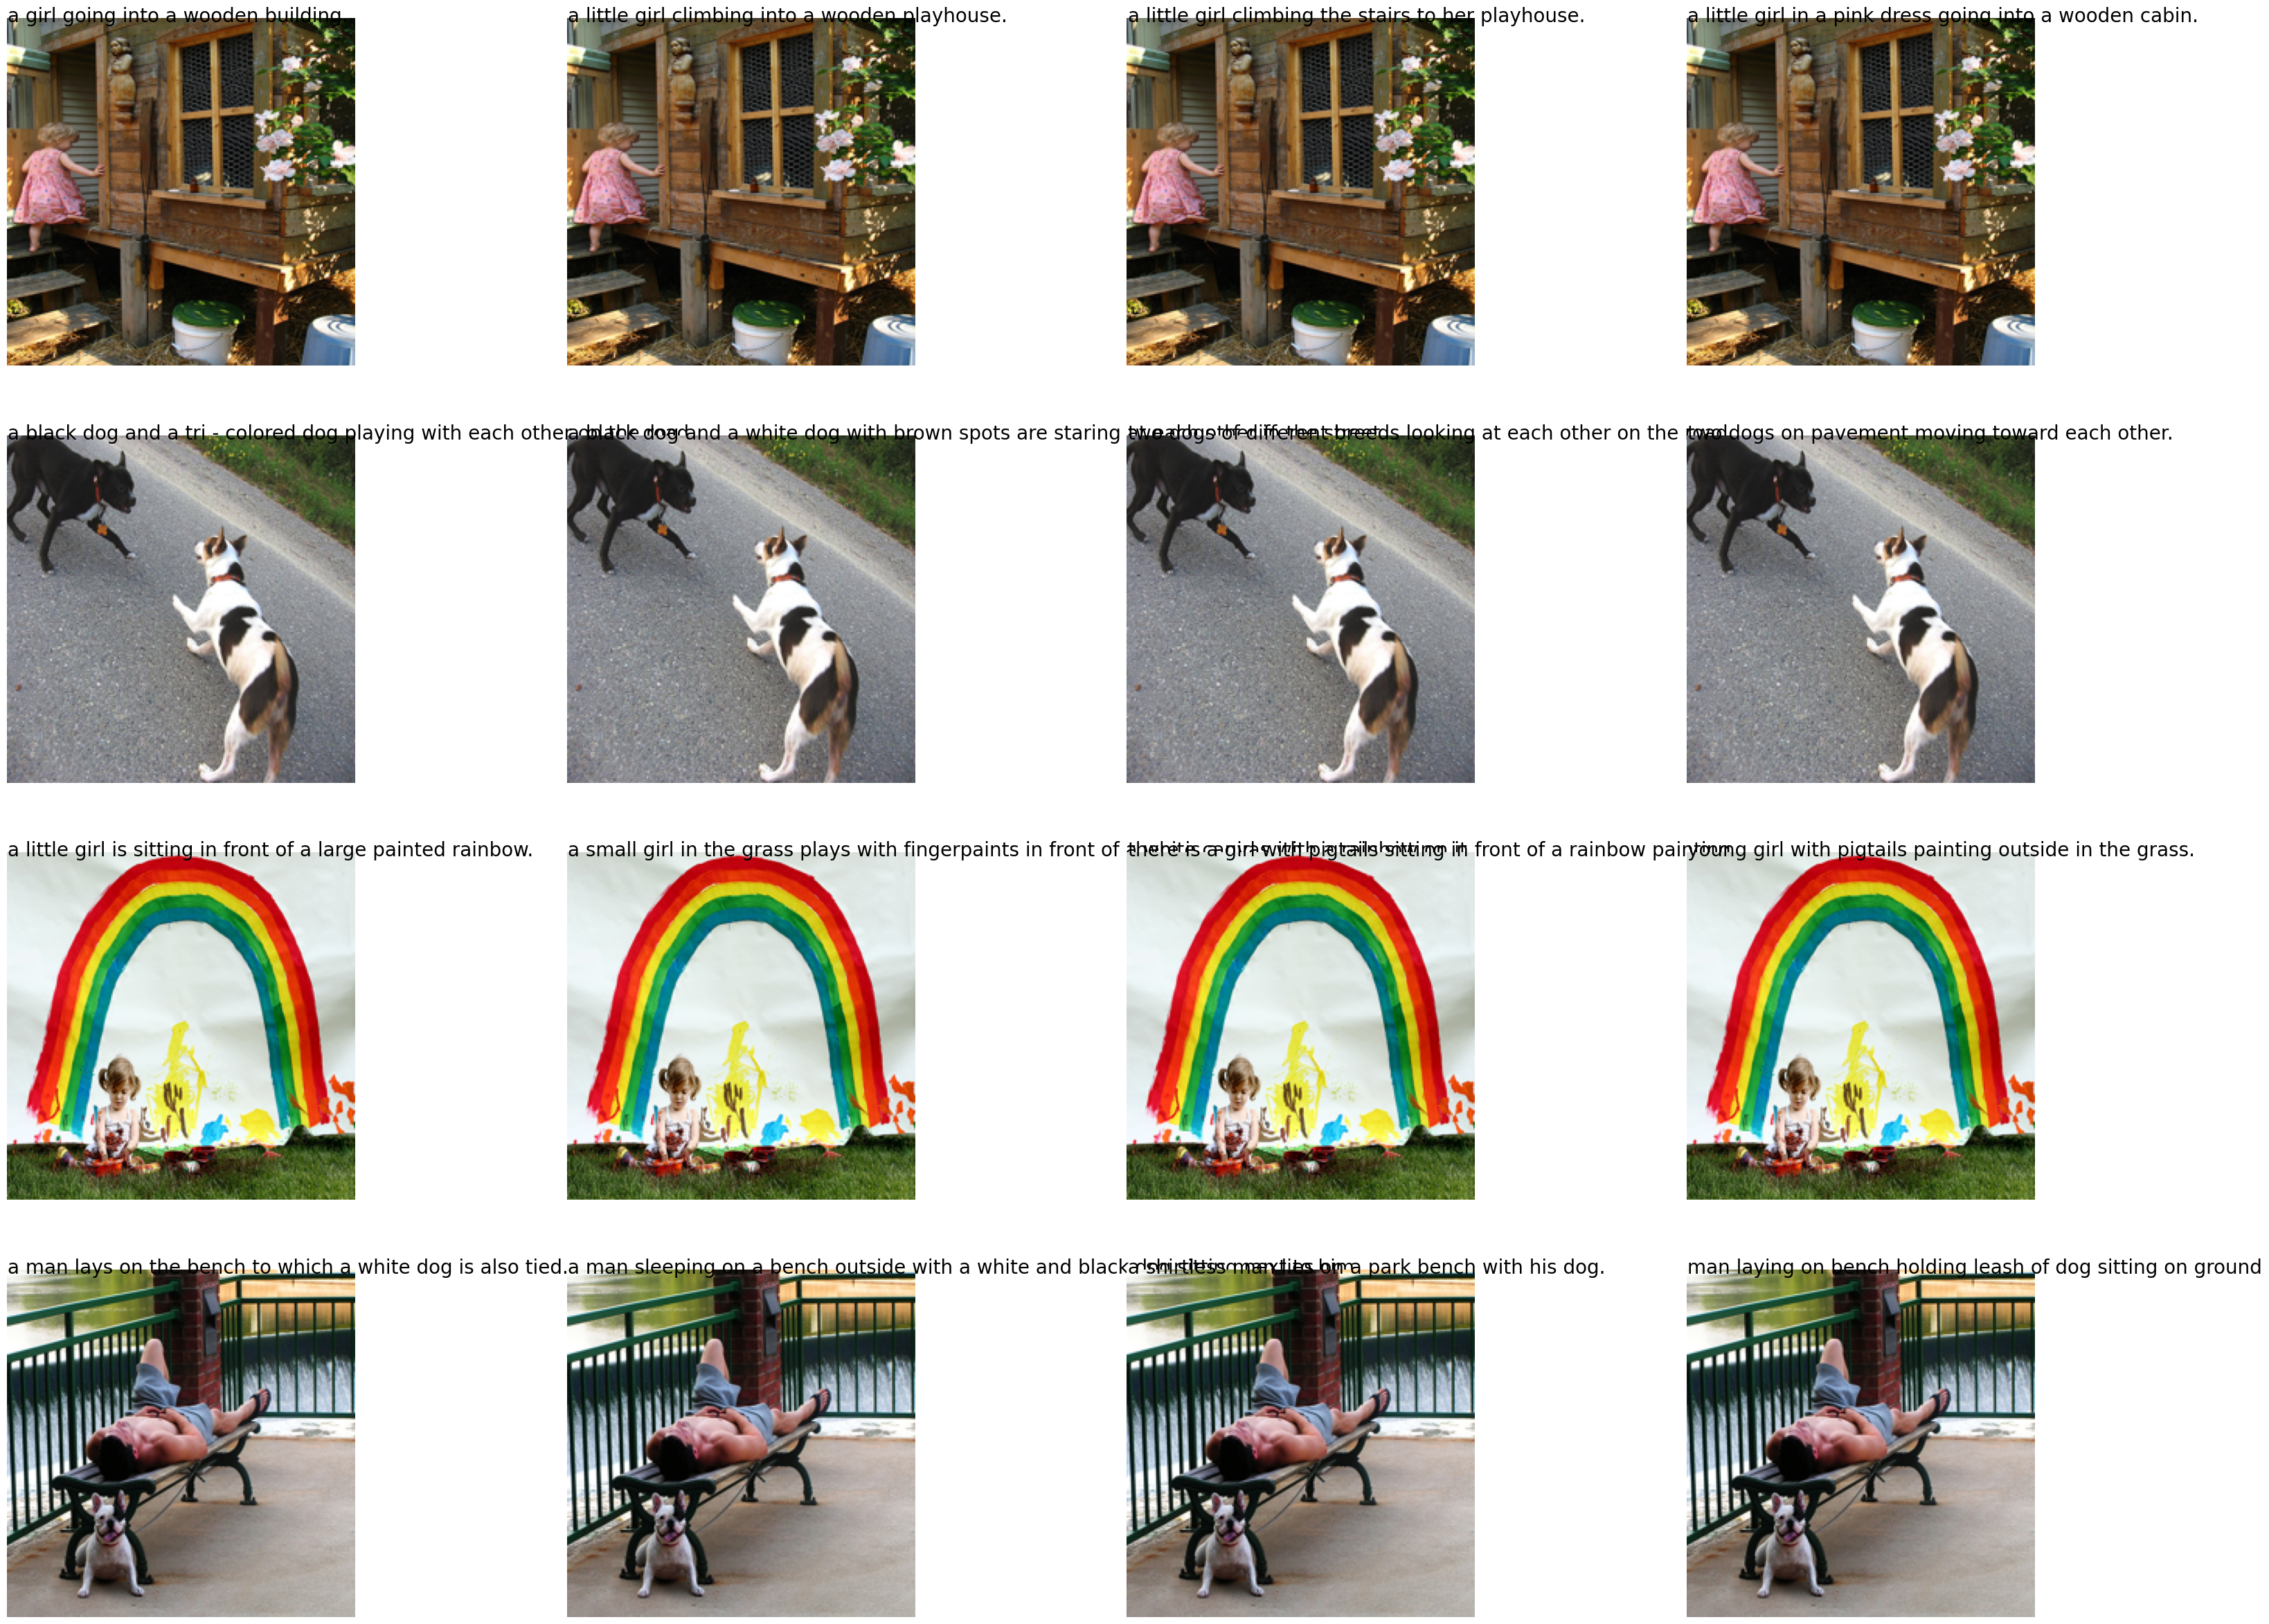

In [8]:
# Display fews images
plt.figure(figsize=(10,10))
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow(np.moveaxis(train_dataset.__getitem__(i)['pixel_values'].numpy(), 0, -1))
    plt.axis('off')
    # caption (small font size)
    caption = []
    for word in decoder_tokenizer.decode( [0 if token==-100 else token for token in train_dataset.__getitem__(i)['caption_token'].numpy()] ).split():
        if word not in decoder_tokenizer.all_special_tokens:
            caption.append(word)
    caption = " ".join(caption)
    plt.text(0, 2, caption, fontsize=20)
    # largen plot size
    plt.gcf().set_size_inches(40, 30)
    
plt.show()

In [9]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)

# Training Setup

In [10]:
from torch.optim import AdamW
optimizer = AdamW(model.parameters(), lr=5e-5)

from transformers import get_scheduler
num_training_steps = epochs * len(train_dataloader)
lr_scheduler = get_scheduler( name="linear", optimizer=optimizer, num_warmup_steps=int(num_training_steps/5), num_training_steps=num_training_steps )


if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")
    
print(device)
# Set GPU/CPU
model.to(device)

cuda


VisionEncoderDecoderModel(
  (encoder): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_featur

# Training Model

In [11]:
from tqdm.auto import tqdm
progress_bar = tqdm(range(num_training_steps))

model.train()
for epoch in range(epochs):
    losses = []
    for batch in train_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(pixel_values = batch['pixel_values'], labels=batch['caption_token']) # decoder_input_ids=batch['caption_token'],
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)
        losses.append(loss)
        
    print('Epoch: {}, Loss: {:.4f}'.format(epoch, sum(losses)))

  0%|          | 0/20240 [00:00<?, ?it/s]

Epoch: 0, Loss: 5051.5801
Epoch: 1, Loss: 2924.7129
Epoch: 2, Loss: 2634.7644
Epoch: 3, Loss: 2441.8772
Epoch: 4, Loss: 2246.7502
Epoch: 5, Loss: 2025.1848
Epoch: 6, Loss: 1819.0488
Epoch: 7, Loss: 1613.2150
Epoch: 8, Loss: 1419.7596
Epoch: 9, Loss: 1249.2167
Epoch: 10, Loss: 1095.7528
Epoch: 11, Loss: 962.0174
Epoch: 12, Loss: 847.1004
Epoch: 13, Loss: 749.2529
Epoch: 14, Loss: 667.8765
Epoch: 15, Loss: 597.0924
Epoch: 16, Loss: 541.0148
Epoch: 17, Loss: 492.5309
Epoch: 18, Loss: 454.6567
Epoch: 19, Loss: 426.7627


# Evaluating Model

In [12]:
metric = evaluate.load('rouge')

model.eval()
losses = []
i = 0
for batch in train_dataloader:
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
        outputs = model(pixel_values=batch['pixel_values'], labels=batch['caption_token'])

    logits = outputs.logits
    loss = outputs.loss
    losses.append(loss)
    predictions = torch.argmax(logits, dim=-1)
    predictions = decoder_tokenizer.batch_decode(predictions,skip_special_tokens=True)
    predictions = [ pred_sen.replace(".","") for pred_sen in predictions ]
    references = [decoder_tokenizer.decode( [0 if token ==-100 else token for token in ref ] ) for ref in batch['caption_token'].tolist() ]
    metric.add_batch( predictions=predictions, references=references )
    
train_rouge_score = metric.compute()
print( " Train Loss: ", torch.sum(torch.tensor(losses)) )
print(" Rouge Score on Train Set: ", train_rouge_score )

 Train Loss:  tensor(275.5357)
 Rouge Score on Train Set:  {'rouge1': 0.34024798597097616, 'rouge2': 0.2858442579857395, 'rougeL': 0.3346287684546293, 'rougeLsum': 0.334667944445752}


In [13]:
metric = evaluate.load('rouge')

model.eval()
losses = []
for batch in val_dataloader:
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
        outputs = model(pixel_values=batch['pixel_values'],labels=batch['caption_token'])
    
    logits = outputs.logits
    loss = outputs.loss
    losses.append(loss)
    predictions = torch.argmax(logits, dim=-1)
    predictions = decoder_tokenizer.batch_decode(predictions,skip_special_tokens=True)
    predictions = [ pred_sen.replace(".","") for pred_sen in predictions ]
    references = [decoder_tokenizer.decode( [0 if token ==-100 else token for token in ref ] ) for ref in batch['caption_token'].tolist() ]
    metric.add_batch( predictions=predictions, references=references )
    
val_rouge_score = metric.compute()
print( " Validation Loss: ", torch.sum(torch.tensor(losses)) )
print(" Rouge Score on Validation Set: ", val_rouge_score )

 Validation Loss:  tensor(69.9571)
 Rouge Score on Validation Set:  {'rouge1': 0.34345484606758925, 'rouge2': 0.2882083268621569, 'rougeL': 0.33772421467039865, 'rougeLsum': 0.33762782549945713}


# Saving Model

In [14]:
# Saving the model, including its configuration
model.save_pretrained("Image_Captioning_Fine_Tune_ViT_BERT_model_flickr8k")

# Generating Captions

/opt/conda/lib/python3.10/site-packages/transformers/generation/utils.py:1259: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use a generation configuration file (see https://huggingface.co/docs/transformers/main_classes/text_generation)
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/transformers/generation/utils.py:1353: UserWarning: Using `max_length`'s default (20) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


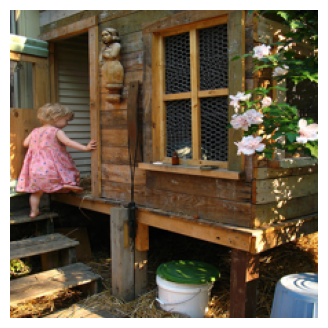

 Generated Caption:   a little girl climbing into a wooden playhouse a little girl in a pink dress


In [15]:
def generate_caption(image, model):
    
    image = torch.unsqueeze( torch.tensor(image), 0)
    predictions = decoder_tokenizer.decode(model.generate(pixel_values=image.to(device))[0],skip_special_tokens=True)
    caption = predictions.replace(".","") 
    
    image = np.moveaxis(image[0].numpy(),0,-1)
    plt.figure(figsize=(4,4))
    plt.imshow(image)
    plt.axis('off')
    plt.show()
    print( " Generated Caption:  ", caption )
    return caption

pred_caption = generate_caption(image=train_dataset.__getitem__(0)['pixel_values'].numpy(), model=model)

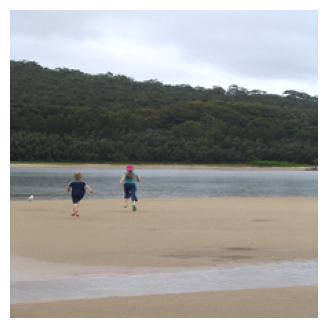

 Generated Caption:   two children run in the sand, along the shore one is carrying a beach ball
---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - 
 



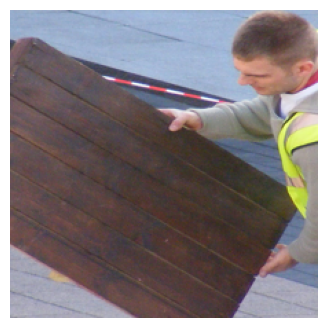

 Generated Caption:   a man in a neon yellow vest carrying a wooden crate a wooden crate a wooden
---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - 
 



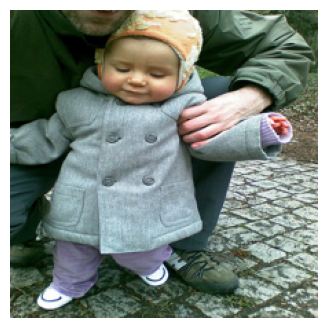

 Generated Caption:   a small child in winter gear is being held steady by an adult the small girl
---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - 
 



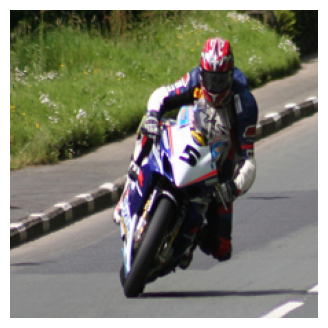

 Generated Caption:   a motorcycle with number five on front is being ridden by a rider wearing a red helmet
---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - 
 



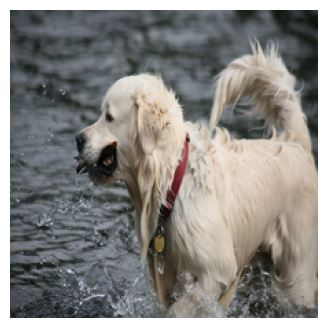

 Generated Caption:   a white dog with red collar splashes in the water a stick a
---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - 
 



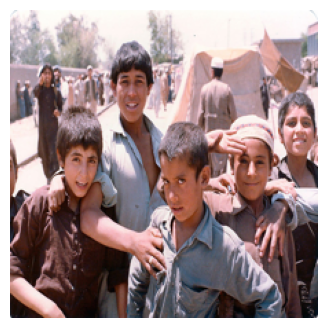

 Generated Caption:   a group of young middle eastern kids posing for the picture a group of four boys
---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - 
 



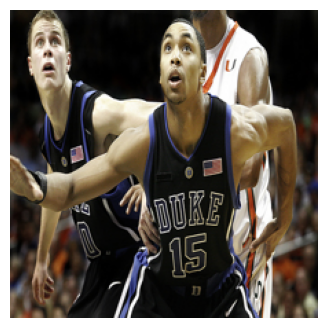

 Generated Caption:   two basketball players from duke are looking upward two men looking upward two men
---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - 
 



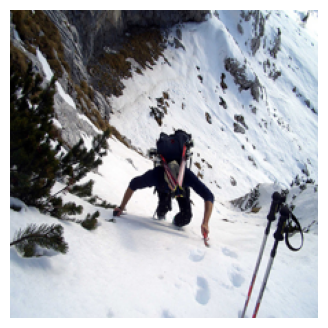

 Generated Caption:   a climber with a backpack accends a snow covered mountain a man with
---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - 
 



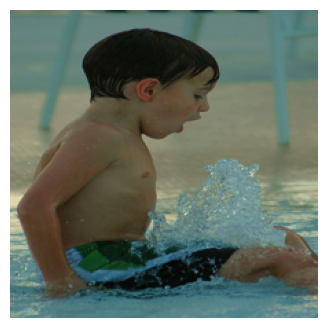

 Generated Caption:   a young boy sitting in water a water jet in his hand a woman
---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - 
 



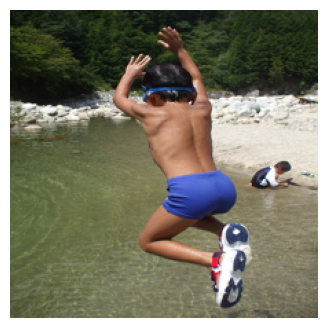

 Generated Caption:   a young boy jumping into a pool with a man in the background a shirtless man
---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - 
 



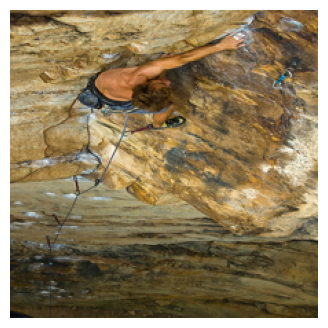

 Generated Caption:   a man wearing no shirt climbs the side of a large rock a man in no
---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - 
 



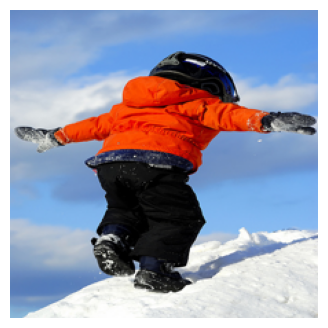

 Generated Caption:   a little boy in red snow pants and a brown coat is snowboarding a girl
---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - 
 



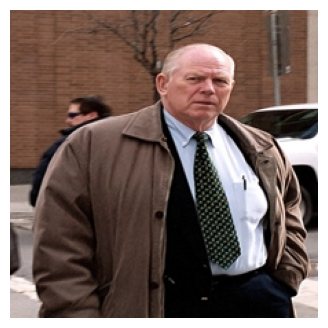

 Generated Caption:   an older man in a suit, tie and overcoat a suit with a tie,
---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - 
 



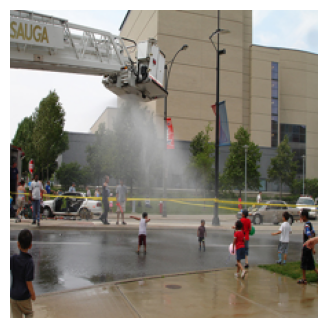

 Generated Caption:   kids playing in the water in the middle of the street kids play under a big
---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - 
 



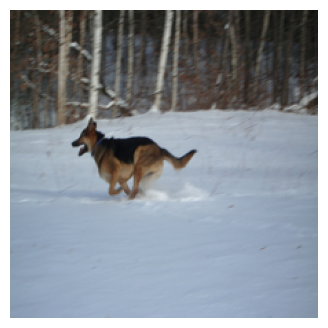

 Generated Caption:   a dog running through snow a german shepherd runs through the snow a german
---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - 
 



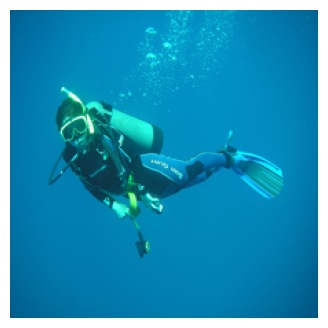

 Generated Caption:   a scuba diver swims underwater while wearing fins underwater diver holds up his
---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - 
 



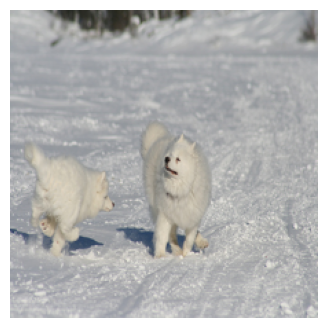

 Generated Caption:   two white dogs play in the snow a third dog is running away a
---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - 
 



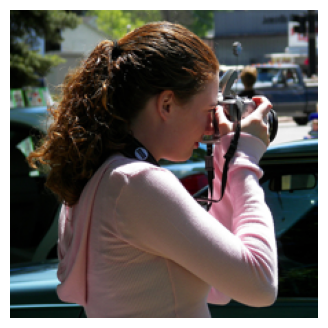

 Generated Caption:   a woman in pink takes a picture during the day a young woman in pink sunglasses
---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - 
 



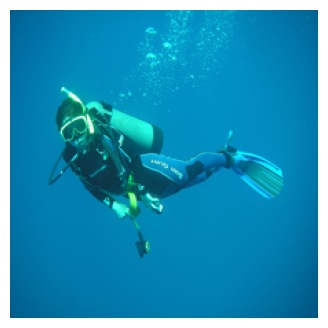

 Generated Caption:   a scuba diver swims underwater while wearing fins underwater diver holds up his
---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - 
 



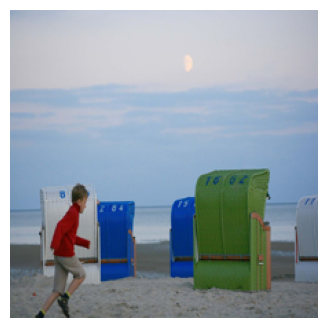

 Generated Caption:   a boy wearing a red shirt runs along a beach a boy in a blue shirt
---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - 
 



In [16]:
for index in np.random.randint(int(text_data_train.shape[0]/4 - 1),size=20):
    pred_caption = generate_caption( image=train_dataset.__getitem__(index)['pixel_values'].numpy(), model=model )
    print( "---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - \n \n" )

In [17]:
print("yo yo")

yo yo


***